In [2]:
%matplotlib inline
from config_calc import *

import os
import sys
import socket
import numpy as np
import xarray as xr

from datetime import datetime
import grid_tools

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

import flux_products

In [3]:
f = '/glade/p/eol/stephens/longcoll/mclong_calcs/flux_products/Takahashi2009-clim-CO2_flux-4x5_to_1x1.nc'
ds = xr.open_dataset(f)
ds

<xarray.Dataset>
Dimensions:   (lat: 180, lon: 360, time: 12)
Coordinates:
  * lat       (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon       (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
  * time      (time) float64 16.0 45.5 75.0 105.5 136.0 166.5 197.0 228.0 ...
Data variables:
    CO2_FLUX  (time, lat, lon) float64 ...
    area      (lat, lon) float32 ...

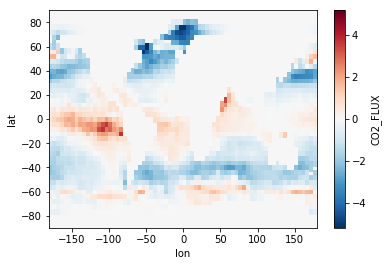

In [4]:
ds.CO2_FLUX.mean(dim='time').plot()

In [10]:
total = (ds.CO2_FLUX * ds.area).sum(dim=['lat','lon']) * 12.e-15
total = (total * xcal.dpm['noleap'] / 365.).sum()
total

<xarray.DataArray ()>
array(-1.3837820837276384)

In [8]:
ds.CO2_FLUX.sum(dim=['lon','lat']).mean(dim='time') * 12.e-15

<xarray.DataArray 'CO2_FLUX' ()>
array(-1.9047231376929738e-10)

In [32]:
import esmf_tools as emsf
droot = os.path.join(dataroot,'pco2-ldeo')
ds = xr.open_dataset(os.path.join(droot,'ldeo_monthly_clim_v2009_c20150807.nc'))
ds = ds.rename({'FLUXMOLM2Y':'CO2_FLUX'})
ds = ds.drop([k for k in ds.variables if k not in ['CO2_FLUX','date','lon','lat','time','AREA_MKM2']])
ds['area'] = ds.AREA_MKM2.isel(time=0,drop=True) * 1e6 * 1e6

ds.area.attrs['units'] = 'm^2'
ds

<xarray.Dataset>
Dimensions:    (lat: 45, lon: 72, time: 12)
Coordinates:
  * time       (time) float64 16.0 45.5 75.0 105.5 136.0 166.5 197.0 228.0 ...
  * lat        (lat) float64 -88.0 -84.0 -80.0 -76.0 -72.0 -68.0 -64.0 -60.0 ...
  * lon        (lon) float64 2.5 7.5 12.5 17.5 22.5 27.5 32.5 37.5 42.5 47.5 ...
Data variables:
    AREA_MKM2  (time, lat, lon) float64 ...
    CO2_FLUX   (time, lat, lon) float64 ...
    date       (time) int32 ...
    area       (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...

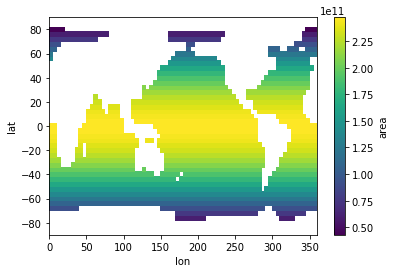

In [33]:
ds.area.plot()

total area = 5.1009969907076156e+14
check area = 5.1009969907076156e+14


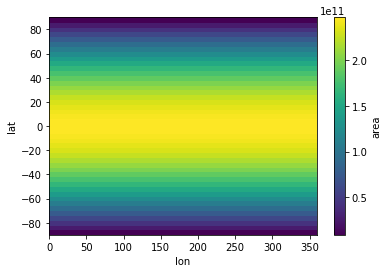

In [34]:
grid4x5 = esmf.reate_grid(ds.lon, ds.lon, xcorners=False, ycorners=False,
                    corners=False, domask=False, doarea=False,
                    ctk=ESMF.TypeKind.R8)

In [11]:
ds.info()

xarray.Dataset {
dimensions:
	lat = 180 ;
	lon = 360 ;
	time = 12 ;

variables:
	float32 lat(lat) ;
	float32 lon(lon) ;
	float64 CO2_FLUX(time, lat, lon) ;
		CO2_FLUX:wgtFile = /glade/p/work/mclong/regrid/weight_files/latlon_4x5_0E_to_latlon_1x1_180W_conserve_20180111.nc ;
		CO2_FLUX:src_file_varname = CO2_FLUX ;
		CO2_FLUX:src_file = /glade/p/eol/stephens/longcoll/mclong_calcs/flux_products/Takahashi2009-clim-CO2_flux-4x5.nc ;
		CO2_FLUX:long_name = CO_2 flux ;
		CO2_FLUX:units = mol C m^{-2} yr^{-1} ;
	float64 time(time) ;
		time:units = julian day ;
	float32 area(lat, lon) ;
		area:wgtFile = /glade/p/work/mclong/regrid/weight_files/latlon_4x5_0E_to_latlon_1x1_180W_conserve_20180111.nc ;
		area:src_file_varname = area ;
		area:src_file = /glade/p/eol/stephens/longcoll/mclong_calcs/flux_products/Takahashi2009-clim-CO2_flux-4x5.nc ;

// global attributes:
}

In [ ]:
    regrid = ESMF.Regrid(srcfield,dstfield,
                         regrid_method=ESMF.RegridMethod.BILINEAR,
                         unmapped_action=ESMF.UnmappedAction.ERROR)